In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
df = pd.read_csv('../csv/ord_vol.csv')

In [7]:
# flake8: noqa: E501

import numpy as np
from numpy.core.fromnumeric import mean
import pandas as pd
from pandas.core.indexes.api import get_objs_combined_axis
import pmdarima
from datetime import datetime
import typing
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error # upgrade to the the latest scikit-learn pip install -U scikit-learn
import random
import copy

from abc import ABC, abstractmethod

class ModelWrapper(ABC):
    def __init__(self, **kwargs):
        try:
            self.__model = kwargs['model']
        except:
            self.__model = None
        
    @abstractmethod
    def fit(self, x):
        pass

    @abstractmethod
    def predict(self, n):
        pass
    def get_model(self):
        return self.__model
    def __str__(self):
        return "ModelWrapper for '{}'".format(str(self.__model))


class AutoArimaWrapper(ModelWrapper):
    def __init__(self, **kwargs):
        self.__kwargs = kwargs
        super().__init__(**kwargs)

    def fit(self, y: typing.Union[list, np.array]):
        kwargs = self.__kwargs.copy()
        try:
            kwargs.pop('y')
        except:
            pass
        self.__model = pmdarima.auto_arima(y=y, **kwargs)

    def predict(self, *args, **kwargs):
        return self.__model.predict(*args, **kwargs)

    def get_conf_int(self, *args, **kwargs):
        _, conf_int = self.__model.predict(*args, return_conf_int=True, **kwargs)
        return conf_int

class KerasWrapper(ModelWrapper):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)




## Changes to be made
## 1 would like to add an argument 

class TSFM(object):
    def __init__(self,
                 df: pd.core.frame.DataFrame, #df is now daily data
                 n_pred_period: int,
                 date_variable: typing.Union[int, str],
                 target_variable: typing.Union[int, str],
                 value_variable: typing.Union[int, str],
                 stop_date: str,         # stop date of train set, to split df to train and test sets
                 model_wrapper: ModelWrapper,
                 input_is_monthly: bool, 
                 output_is_monthly: bool,
                 section_list: list = None,
                 alpha: float = 0.05,):
                #  stepwise: bool = True,
                # cycle_length: int = 12,
                #  start_order: tuple = (0, 1, 0),
                #  max_order: tuple = (4, 2, 5),
                #  start_seasonal_order: tuple = (0, 1, 0),
                #  max_seasonal_order: tuple = (2, 2, 4)):
        self.target_variable = target_variable
        # self.n_pred_period = n_pred_period + abs((datetime.strptime(df[date_variable].to_numpy()[-1])  - datetime.strptime(stop_date, "%Y-%m-%d")).days)
        self.n_pred_period = n_pred_period
        self.stop_date = stop_date
        self.model_wrapper = model_wrapper
        self.input_is_monthly = input_is_monthly
        self.output_is_monthly = output_is_monthly
        self.alpha = alpha
        # self.stepwise = stepwise
        # self.start_order = start_order
        # self.max_order = max_order
        # self.start_seasonal_order = start_seasonal_order
        # self.max_seasonal_order = max_seasonal_order

        self.is_log_transformed_dict = dict()
        self.pred_dict = dict()
        self.pred_ic_dict = dict()
        self.adjusted_pred_dict = dict()
        self.adjusted_pred_ic_dict = dict()

        # train and test df must have date as index, and 2 columns: sections(e.g. territory) and values(e.g. order_volume)
        if type(date_variable) is int:
            date_variable = df.columns[date_variable]
        if type(value_variable) is int:
            value_variable = df.columns[value_variable]
        if type(target_variable) is int:
            target_variable = df.columns[target_variable]
        # Select relevant columns for train and test df, create empty pred df
        self.columns = [date_variable, target_variable, value_variable]
        df[self.columns[0]] = pd.to_datetime(df[self.columns[0]])
        

        
        if input_is_monthly and not output_is_monthly:
            print("Monthly to daily is not yet supported")
            return
        self.df = df.copy()

        # keys: sections(territories), value: list(train, test, pred), for easy storing and fetching data
        self.df_dict = dict()
        self.model_dict = dict()
        self.adjusted_model_dict = dict()

        # Iterate through the unique sections
        self.section_list = section_list
        if self.section_list is None:
            self.section_list = df[target_variable].unique()
        for section in self.section_list:
            self.is_log_transformed_dict[section] = False
            models = self.__train_models(section = section)
            if self.__have_negative_prediction(models=models):
                print("Negative prediction detected in", section)
                self.is_log_transformed_dict[section] = True
                models = self.__train_models(section = section)
            (model, adjusted_model) = models
            self.model_dict[section] = model
            self.adjusted_model_dict[section] = adjusted_model
            self.pred_dict[section], self.pred_ic_dict[section] = self.__get_pred_data(section=section, return_conf_int=True, is_adjusted=False)
            self.adjusted_pred_dict[section], self.adjusted_pred_ic_dict[section] = self.__get_pred_data(section=section, return_conf_int=True, is_adjusted=True)

    # DF Getters--------------------------------------------------------------
    def get_actual_data(self, section: str, is_adjusted: bool, is_log_transformed: bool = None) -> pd.core.frame.DataFrame:
        '''
        Returns the input data of a section with or without transformations.
        * section: str: an element in the unique list of target variables.
        * is_adjusted: bool: determine if the returning data is adjusted by the anomally filter.
        * is_log_transformed: bool = None: determine if the returning data is log transformed. If is None then it's value is determined by self.is_log_transformed_dict[section]
        '''
        agg_df = self.df[self.columns].groupby(self.columns[0:2], as_index=False).sum().copy()
        agg_df = agg_df.query(self.columns[1] + "==" + "'" + section + "'")[[self.columns[0], self.columns[2]]]
        agg_df.set_index(self.columns[0], inplace=True)
        if not self.input_is_monthly and self.output_is_monthly:
            full_daily_df, remainder_daily_df = self.get_full_month_data(df=agg_df.copy())
            agg_df = TSFM.to_monthly(full_daily_df)
        if is_adjusted and self.output_is_monthly:
            agg_df = self.anomaly_filter(agg_df, alpha = self.alpha)
        if is_log_transformed is None:
            is_log_transformed = self.is_log_transformed_dict[section]
        if is_log_transformed:
            agg_df = TSFM.log_transform(agg_df)
        return agg_df

    def get_train_data(self, section: str):
        '''
        Returns the training data for the anomaly filter method.
        * section: str: an element in the unique list of target variables.
        '''
        actual_df = self.get_actual_data(section, is_adjusted=False)
        return actual_df.iloc[lambda x: x.index <= self.stop_date].copy()

    def get_test_data(self, section: str, ):
        actual_df = self.get_actual_data(section, is_adjusted=False)
        return actual_df.iloc[lambda x: x.index > self.stop_date].copy()

    def get_pred_data(self, section: str, is_adjusted: bool, return_conf_int: bool = False):
        pred, ic = None, None
        if is_adjusted:
            pred, ic = self.adjusted_pred_dict[section], self.adjusted_pred_ic_dict[section]
        else:
            pred, ic = self.pred_dict[section], self.pred_ic_dict[section]
        if return_conf_int:
            return pred, ic
        return pred

    def get_full_month_data(self, df):
        max_date = df.index.max()
        if self.__is_last_day_of_month(max_date):
            return df, None
        new_date =  max_date.year + '-' + max_date.month + '-' + max_date.day
        return df.query(self.columns[0] + "<'" + new_date + "'"), df.query(self.columns[0] + ">='" + new_date + "'")
        

    def __is_last_day_of_month(self, date):
        next_day = date + pd.DateOffset(days=1)
        if date.month == next_day.month:
            return False
        return True


    def __get_pred_data(self, section: str, return_conf_int: bool = False, is_adjusted: bool = True):
        actual_df = self.get_actual_data(section, False)
        model = self.get_model(section=section, is_adjusted=is_adjusted)
        if self.output_is_monthly:
            freq = 'MS'
        else:
            freq = 'D'
        if model is None:
            print("Model of", section, "section was not initiated. Might due to insufficient training data.")
            return None
        pred  = model.predict(self.n_pred_period)
        conf_int = model.get_conf_int(self.n_pred_period)
        temp_pred_df = pd.DataFrame(
            data={
                self.columns[0]: pd.date_range(max(actual_df.index),freq='D',periods=self.n_pred_period+1)[1:],
                self.columns[1]: [section for x in range(len(pred))],
                self.columns[-1]: pred})  # Use numbers inplace of future dates for now)
        temp_pred_df = temp_pred_df[[self.columns[0], self.columns[2]]]
        temp_pred_df.set_index(self.columns[0], inplace=True)
        if self.is_log_transformed_dict[section]:
            temp_pred_df = self.exp_transform(temp_pred_df)
        if return_conf_int:
            return temp_pred_df.copy(), conf_int
        return temp_pred_df.copy()

    def get_pred_df(self):
        '''
        function to be called in the backend to get pred data from all sections
        '''
        return_df = pd.DataFrame(columns=self.columns)
        for section in self.section_list:
            actual_pred = self.get_pred_data(section, is_adjusted=False)
            adjusted_actual_pred = self.get_pred_data(section, is_adjusted=True)
            pred = pd.DataFrame(data={actual_pred.columns[0]: actual_pred[actual_pred.columns[0]].to_numpy(), "value2": adjusted_actual_pred[adjusted_actual_pred.columns[0]].to_numpy()},
                                index = actual_pred.index)
            pred.reset_index(inplace=True)
            pred[self.target_variable] = [section for x in range(pred.shape[0])]
            return_df = return_df.append(pred, ignore_index=True)
        return_df.sort_values(by=[self.columns[1], self.columns[0]], inplace=True, ignore_index=True)
        return return_df

    # Model Getters----------------------------------------------------------
    def get_model(self, section: str, is_adjusted: bool):
        if is_adjusted:
            return self.adjusted_model_dict[section]
        return self.model_dict[section]
    
    # Plot Function-----------------------------------------------------------
    def plot(self, section: str):
        actual = self.get_actual_data(section, is_adjusted=False)
        adjusted_actual, conf_int_df = self.anomaly_filter(actual, return_conf_int=True, alpha = self.alpha)
        # pred, ci = self.get_pred_data(section, return_conf_int=True)

        actual_pred = self.get_pred_data(section, is_adjusted=False)
        adjusted_actual_pred = self.get_pred_data(section, is_adjusted=True)

        fig, ax = plt.subplots(figsize=(14,6))
        ax.plot(actual.index, actual[actual.columns[0]].to_numpy(),label="Actual")   #Actuals This should come from original DS (all actuals)
        ax.plot(adjusted_actual.index, adjusted_actual[adjusted_actual.columns[0]].to_numpy(),'-g', label="Adjusted Actual")   
        # ax.plot(pred.index, pred[pred.columns[0]], '-r',alpha=0.75,label="Forecast")  ## Pred
        ax.fill_between(conf_int_df.index, conf_int_df.iloc[:, 0], conf_int_df.iloc[:, 1],alpha=0.3, color='b')  ## Conf intervals
        
        ax.plot(actual_pred.index, actual_pred.iloc[:, 0], '--b',alpha=0.75,label="Actual Forecast")
        ax.plot(adjusted_actual_pred.index, adjusted_actual_pred.iloc[:, 0], '--g',alpha=0.75,label="Adjusted Actual Forecast")
        plt.title('Forecast Model')
        plt.xlabel('Year')
        plt.ylabel('Forecast Accurary')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())

        plt.legend()
        plt.show()

    def anomaly_filter(self,
                       df: pd.core.frame.DataFrame,
                       return_conf_int: bool = False, 
                       n_rolling_period: int = 12,
                       alpha: float = 0.05):
        print("Applying anomaly filter...")
        df = df.copy()
        train = df.iloc[lambda x: x.index <= self.stop_date]
        returning_ic_list = list()
        (start_p, start_d, start_q) = (0, 1, 0)
        (max_p, max_d, max_q) = (4, 2, 5)
        (start_P, start_D, start_Q) = (0, 1, 0)
        (max_P, max_D, max_Q) = (2, 2, 4)
        for i in range(train.shape[0], df.shape[0], n_rolling_period):
            arima_model = pmdarima.auto_arima(train[train.columns[0]],
                                                start_p=start_p, start_P=start_P,
                                                start_q=start_q, start_Q=start_Q,
                                                d=start_d, D=start_D,
                                                max_p=max_p, max_P=max_P,
                                                max_d=max_d, max_D=max_D,
                                                max_q=max_q, max_Q=max_Q,
                                                trace=True, m=12, stepwise=False)
            temp_actual_df = df.iloc[i:min(i+n_rolling_period, df.shape[0]), :].copy()
            temp_pred, ic_list = arima_model.predict(n_rolling_period, return_conf_int=True, alpha=alpha)
            print("ic_list", ic_list)
            for j in range(temp_actual_df.shape[0]):
                temp_actual = temp_actual_df.iloc[j, 0]
                ic = ic_list[j]
                if temp_actual < ic[0] or temp_actual > ic[1]:
                    temp_actual_df.iloc[j, 0] = temp_pred[j]
            train = train.append(temp_actual_df)
            returning_ic_list = returning_ic_list + ic_list.tolist()
        train[train.columns[0]] = train[train.columns[0]].astype('float')
        train = train.asfreq('MS')
        if return_conf_int:
            returning_ic_list = np.array(returning_ic_list)
            print("returning_ic_list", returning_ic_list)
            ic_df = pd.DataFrame(
                data={
                    'lower': returning_ic_list[:, 0],
                    'upper': returning_ic_list[:, 1],
                },
                index=pd.date_range(self.stop_date,freq='MS',periods=returning_ic_list.shape[0]+1)[1:]
            )
            return train.copy(), ic_df
        return train.copy()
    
    def cross_validate(self,section: str, is_adjusted: bool):
        actual_df = self.get_actual_data(section, is_adjusted)
        actual_arr = actual_df[actual_df.columns[0]].to_numpy(dtype='float')
        trained_model = self.get_model(section, is_adjusted)
        order = trained_model.order
        seasonal_order = trained_model.seasonal_order

        model = copy.copy(self.model_wrapper)
        MAE = list()
        MAPE = list()
        tscv = TimeSeriesSplit(10)
        for train_index, test_index in tscv.split(X=actual_df.index):
            if len(train_index) >= 24:
                print("train_index = {}".format(train_index))
                print("test_index = {}".format(test_index))
                train = actual_arr[train_index]
                test = actual_arr[test_index]
                print("train = {}".format(train))
                print("test = {}".format(test))
                model.fit(train)
                pred = model.predict(len(test))
                mae = mean_absolute_error(test, pred)
                mape = mean_absolute_percentage_error(test, pred)
                MAE.append(mae)
                MAPE.append(mape)
                
                print("MAE = {}".format(mae))
                print("MAPE = {}".format(mape))
                print("-"*50)
            else:
                pass
        print("MAE = {}".format(MAE))
        print("MAPE = {}".format(MAPE))
        print("Average MAE = {}".format(np.mean(MAE)))
        print("Average MAPE = {}".format(np.mean(MAPE)))

    def __train_models(self, section: str) -> tuple:
        # (start_p, start_d, start_q) = self.start_order
        # (max_p, max_d, max_q) = self.max_order
        # (start_P, start_D, start_Q) = self.start_seasonal_order
        # (max_P, max_D, max_Q) = self.max_seasonal_order
    
        print("Inspecting", section, "...")
        temp_actual_df = self.get_actual_data(section=section, is_adjusted=False, is_log_transformed=self.is_log_transformed_dict[section])
        temp_adjusted_actual_df = self.get_actual_data(section=section, is_adjusted=True, is_log_transformed=self.is_log_transformed_dict[section])
        if temp_actual_df.shape[0] >= 2 * 12:
            # train actual data
            print("Training", temp_actual_df.shape[0], "actual records ...")
            model_wrapper = copy.copy(self.model_wrapper)
            model_wrapper.fit(temp_actual_df[temp_actual_df.columns[-1]])

            # train adjusted actual data
            print("Training", temp_adjusted_actual_df.shape[0], "adjusted actual records ...")
            adjusted_model_wrapper = copy.copy(self.model_wrapper)
            adjusted_model_wrapper.fit(temp_adjusted_actual_df[temp_adjusted_actual_df.columns[-1]])
            return model_wrapper, adjusted_model_wrapper
        print("Number of data points in Section", section, "is too small (" + str(
            temp_actual_df.shape[0]) + ". Must be at least twice the declared cycle length.")
        return None, None

    def __have_negative_prediction(self, models: tuple) -> bool:
        (model, adjusted_model) = models
        if model is None or adjusted_model is None:
            return False
        pred = model.predict(self.n_pred_period)
        adjusted_pred = adjusted_model.predict(self.n_pred_period)
        if min(min(pred), min(adjusted_pred)) < 0:
            return True
        return False

    @staticmethod
    def log_transform(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        '''
        df has 1 value column and has dates as indeces
        '''
        value_arr = df.loc[:, df.columns[0]].values.copy()
        value_arr[value_arr < 1] = 1 # avoid negative results from transformation
        value_arr = np.log(value_arr)
        return  pd.DataFrame(index=df.index, data={df.columns[0]: value_arr})
    
    @staticmethod
    def exp_transform(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        '''
        df has 1 value column and has dates as indeces
        '''
        value_arr = df.loc[:, df.columns[0]].values.copy()
        value_arr = np.exp(value_arr)
        return  pd.DataFrame(index=df.index, data={df.columns[0]: value_arr})

    @classmethod
    def to_monthly(cls, df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        return df.resample('MS').sum()

    def foo():
        return


In [8]:
auto_arima_wrapper = AutoArimaWrapper(start_p=0, start_P=0,
                                        d=1, D=1,
                                        start_q=0, start_Q=0,
                                        max_p=4, max_P=2,
                                        max_d=2, max_D=2,
                                        max_q=5, max_Q=4,
                                        trace=True, m=12,stepwise=True)

In [12]:
tsfm = TSFM(df=df, n_pred_period=24, date_variable='beg_month', target_variable='product', value_variable='ro', stop_date="2020-03-01", section_list=["HOME", "ACUTE"], model_wrapper=auto_arima_wrapper, input_is_monthly=True, output_is_monthly=True)

on3.8/site-packages/statsmodels/tsa/statespace/representation.py", line 985, in _initialize_state
    self._statespaces[prefix].initialize(self.initialization,
  File "statsmodels/tsa/statespace/_representation.pyx", line 1373, in statsmodels.tsa.statespace._representation.dStatespace.initialize
  File "statsmodels/tsa/statespace/_representation.pyx", line 1362, in statsmodels.tsa.statespace._representation.dStatespace.initialize
  File "statsmodels/tsa/statespace/_initialization.pyx", line 288, in statsmodels.tsa.statespace._initialization.dInitialization.initialize
  File "statsmodels/tsa/statespace/_initialization.pyx", line 406, in statsmodels.tsa.statespace._initialization.dInitialization.initialize_stationary_stationary_cov
  File "statsmodels/tsa/statespace/_tools.pyx", line 1206, in statsmodels.tsa.statespace._tools._dsolve_discrete_lyapunov
numpy.linalg.LinAlgError: LU decomposition error.

  warnings.warn(warning_str, ModelFitWarning)
 ARIMA(0,1,0)(2,1,0)[12]             : AI

Applying anomaly filter...
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=412.762, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=414.762, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=416.573, Time=0.69 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=inf, Time=3.35 sec
 ARIMA(0,1,0)(0,1,4)[12]             : AIC=419.692, Time=2.21 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=414.748, Time=0.27 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=416.718, Time=1.17 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=4.64 sec
 ARIMA(0,1,0)(1,1,4)[12]             : AIC=421.596, Time=7.69 sec
/home/tiendatngcs/.local/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,1,0)(2,1,0)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/home/tiendatngcs/.local/lib/python3.8/

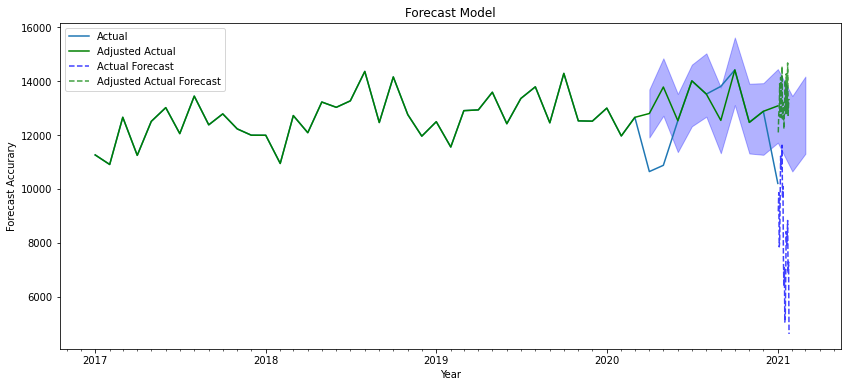

In [14]:
tsfm.plot("HOME")